# Начнем исследование с подключения всех необходимых библиотек.

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer


# Загрузим наш датасет.
dataset_url = '/content/smartphones.csv'
df = pd.read_csv(dataset_url)

# Посмотрим на первые несколько строк нашего датасета, чтобы понять его структуру.
df.head()

,Smartphone,Brand,Model,RAM,Storage,Color,Free,Final Price
0,Realme C55 8/256GB Sunshower Libre,Realme,C55,8.0,256.0,Yellow,Yes,231.60
1,Samsung Galaxy M23 5G 4/128GB Azul Libre,Samsung,Galaxy M23,4.0,128.0,Blue,Yes,279.00
2,Motorola Moto G13 4/128GB Azul Lavanda Libre,Motorola,Moto G13,4.0,128.0,Blue,Yes,179.01
3,Xiaomi Redmi Note 11S 6/128GB Gris Libre,Xiaomi,Redmi Note 11S,6.0,128.0,Gray,Yes,279.99
4,Nothing Phone (2) 12/512GB Blanco Libre,Nothing,Phone (2),12.0,512.0,White,Yes,799.00


### Проведем разведочный анализ наших данных.

Smartphone           0
RAM                483
Storage             25
Free                 0
Final Price          0
                  ... 
Color_Red            0
Color_Silver         0
Color_Turquoise      0
Color_White          0
Color_Yellow         0
Length: 442, dtype: int64


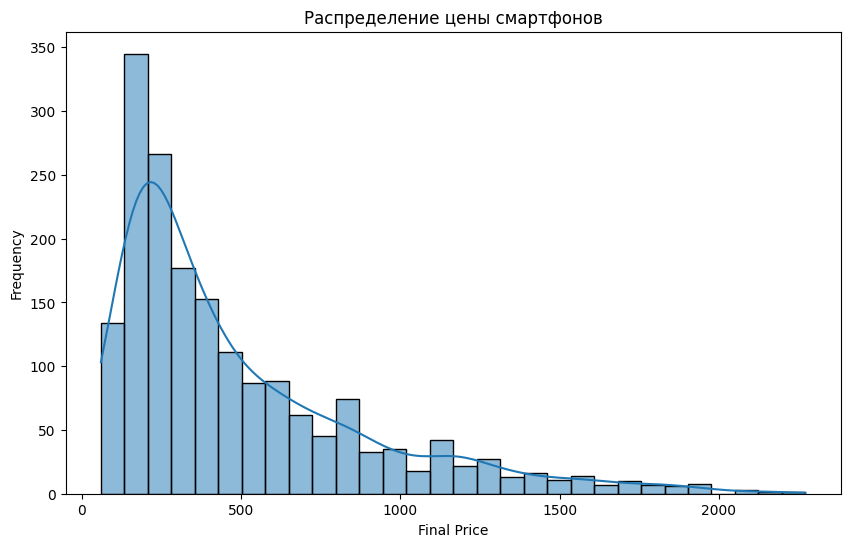

In [19]:
# Проверим основные статистические показатели нашего датасета.
df.describe(include='all')

# Проверим наличие пропущенных значений.
print(df.isnull().sum())

import matplotlib.pyplot as plt
import seaborn as sns

# Построим распределение целевой переменной - Final Price
plt.figure(figsize=(10, 6))
sns.histplot(df['Final Price'], kde=True)
plt.title('Распределение цены смартфонов')
plt.xlabel('Final Price')
plt.ylabel('Frequency')
plt.show()

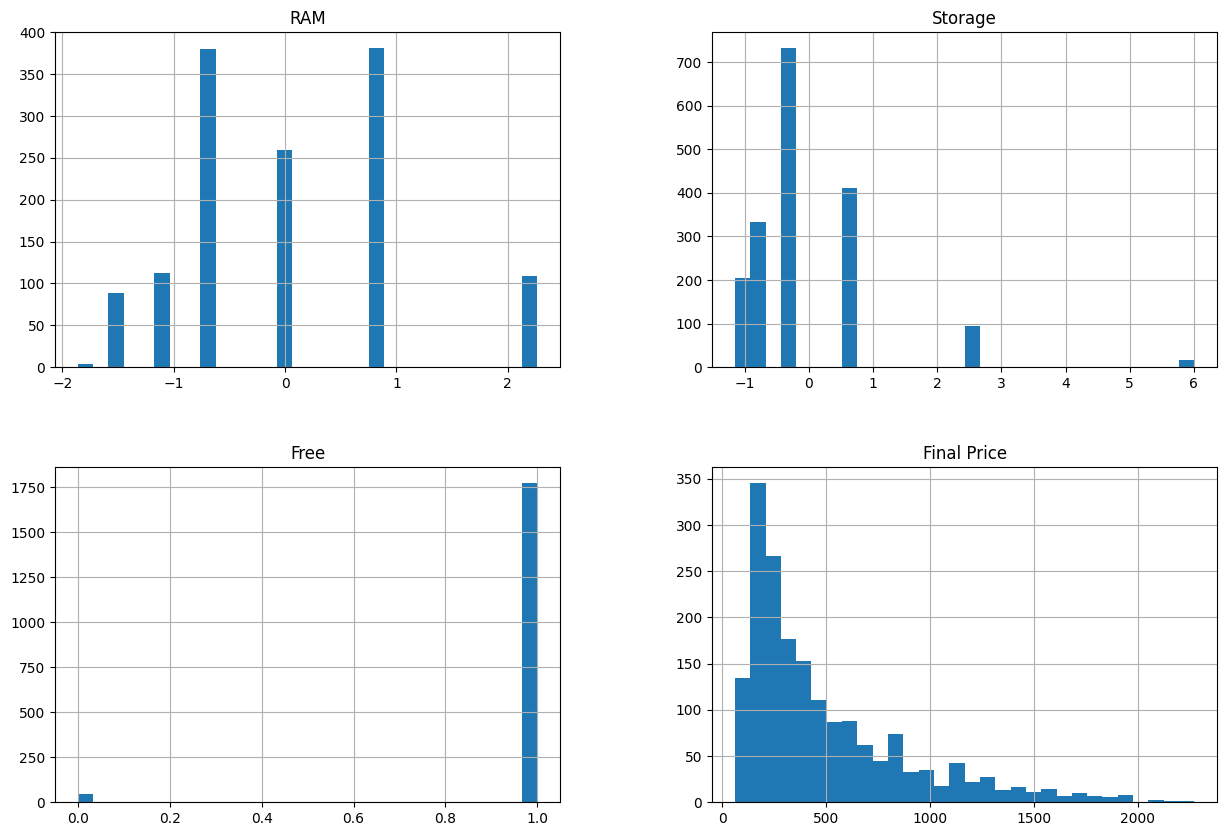

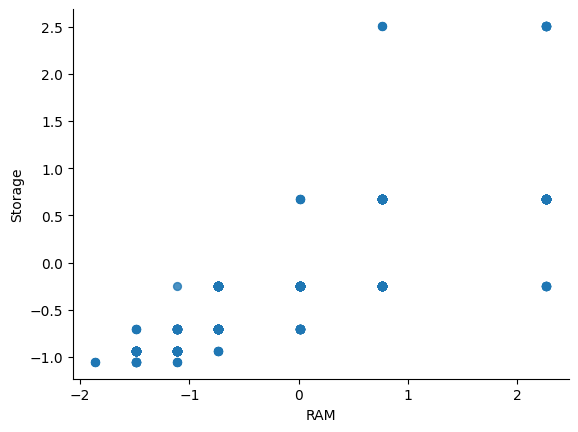

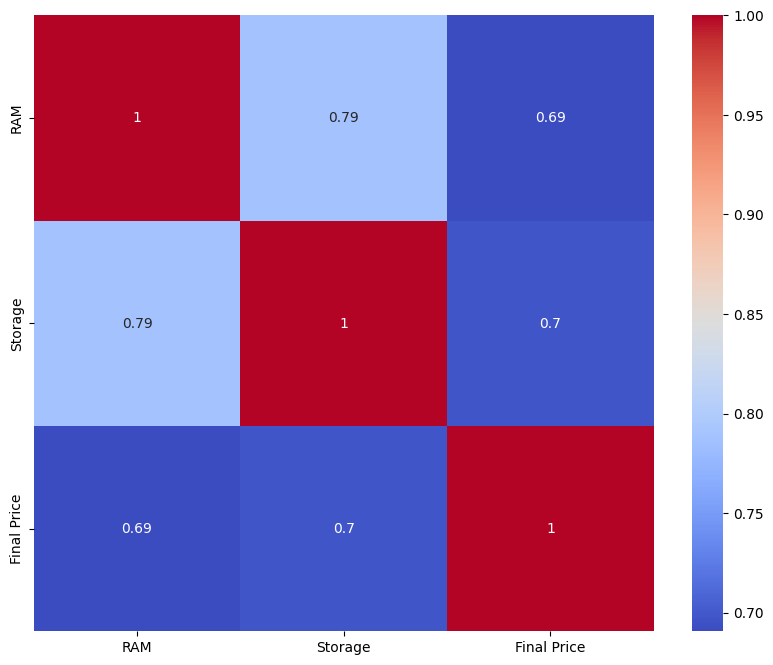

In [20]:
# Гистограммы числовых признаков
df.hist(bins=30, figsize=(15,10))
plt.show()
print('\n')
df.plot(kind='scatter', x='RAM', y='Storage', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.show()
# Корреляционная матрица числовых признаков
print('\n')
plt.figure(figsize=(10,8))
sns.heatmap(df[['RAM', 'Storage', 'Final Price']].corr(), annot=True, cmap='coolwarm')
plt.show()



**На матрице видно, что память обладает взаимной высокой положительной корреляцией, также оба вида памяти на 0.7 коррелированы с конечной ценой телефона**

### Проведем предобработку данных.

In [4]:
# Выбор признаков, подходящих для построения моделей
# Кодирование категориальных признаков (Brand, Model, Color, Free)
# Масштабирование данных (RAM, Storage)

df.dropna()
# Кодирование категориальных признаков
df['Free'] = df['Free'].map({'Yes': 1, 'No': 0})

# del df['Smartphone']
# Применим кодирование 'One-Hot Encoding' для Brand, Model и Color
df = pd.get_dummies(df, columns=['Brand', 'Model', 'Color'])


# Масштабирование RAM и Storage
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df[['RAM', 'Storage']] = scaler.fit_transform(df[['RAM', 'Storage']])

# Проверим результат
df.head()

,Smartphone,RAM,Storage,Free,Final Price,Brand_Alcatel,Brand_Apple,Brand_Asus,Brand_BQ,Brand_Blackview,...,Color_Green,Color_Orange,Color_Pink,Color_Purple,Color_Rainbow,Color_Red,Color_Silver,Color_Turquoise,Color_White,Color_Yellow
0,Realme C55 8/256GB Sunshower Libre,0.764513,0.669772,1,231.60,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,Samsung Galaxy M23 5G 4/128GB Azul Libre,-0.735260,-0.248629,1,279.00,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Motorola Moto G13 4/128GB Azul Lavanda Libre,-0.735260,-0.248629,1,179.01,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Xiaomi Redmi Note 11S 6/128GB Gris Libre,0.014626,-0.248629,1,279.99,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Nothing Phone (2) 12/512GB Blanco Libre,2.264287,2.506573,1,799.00,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


# Выбор метрик для оценки качества моделей


Для оценки качества моделей регрессии мы выберем следующие три метрики:

1. ***R^2*** (коэффициент детерминации): Он показывает, какую часть дисперсии зависимой переменной объясняют независимые переменные. Это очень популярная метрика для оценки качества регрессионных моделей.
   
2. ***MAE*** (средняя абсолютная ошибка): Данная метрика позволяет оценить среднюю абсолютную ошибку в предсказаниях, что помогает нам понять среднюю разницу между фактическим и предсказанным значениями.
   
3. ***RMSE*** (квадратичная средняя ошибка): Является более чувствительной к большим отклонениям между фактическим и предсказанным значениями, чем MAE, и часто используется в задачах регрессии.

In [5]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Определим функции для вычисления выбранных метрик
def evaluate_model(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return {"R^2": r2, "MAE": mae, "RMSE": rmse}

# Выбор моделей для решения задачи регрессии

Мы будем использовать следующие модели регрессии:
1. Метод К-ближайших соседей
2. Решающее дерево
3. Метод опорных векторов
4. Ансамблевая модель случайного леса
5. Градиентный бустинг

In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

# Создаём модели

models = {
    "Decision Tree": DecisionTreeRegressor(),
    "Support Vector Machine": SVR(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "K-Neighbors": KNeighborsRegressor()
}

### Сформируем обучающую и тестовую выборки:

In [7]:
from sklearn.model_selection import train_test_split

# Разделим наш датасет на признаки и целевую переменную
df.dropna()
X = df.drop(columns=['Final Price', "Smartphone"])
y = df['Final Price']

# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Baseline модели
Построим базовые модели и сделаем предсказания

In [8]:
baseline_results = {}
imputer = SimpleImputer(strategy='most_frequent')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)


for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    baseline_results[name] = evaluate_model(y_test, y_pred)

print("Baseline Results")
for name, metrics in baseline_results.items():
    print(f"{name}: R^2: {metrics['R^2']:.4f}, MAE: {metrics['MAE']:.4f}, RMSE: {metrics['RMSE']:.4f}")

Baseline Results
Decision Tree: R^2: 0.7305, MAE: 128.4222, RMSE: 225.2939
Support Vector Machine: R^2: -0.0467, MAE: 280.7735, RMSE: 443.9565
Random Forest: R^2: 0.7903, MAE: 117.9124, RMSE: 198.7391
Gradient Boosting: R^2: 0.7638, MAE: 142.9338, RMSE: 210.8953
K-Neighbors: R^2: 0.7583, MAE: 136.5227, RMSE: 213.3348


### Подберем гиперпараметры выбранных моделей

In [9]:
from sklearn.model_selection import GridSearchCV

# Определим гиперпараметры для каждой модели

# Решающее дерево
dt_params = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Метод опорных векторов
svr_params = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.1, 1]
}

# Случайный лес
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Градиентный бустинг
gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0],
    'max_depth': [3, 7, 10]
}

# K-Neighbors Regressor
knn_params = {
    'n_neighbors': [3, 5, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Словарь параметров
params = {
    "Decision Tree": dt_params,
    "Support Vector Machine": svr_params,
    "Random Forest": rf_params,
    "Gradient Boosting": gb_params,
    "K-Neighbors": knn_params
}

# Используем GridSearchCV для подбора оптимальных параметров для каждой модели
best_params = {}
for name, model in models.items():
    print(f"Подбор гиперпараметров для {name}...")
    grid_search = GridSearchCV(model, params[name], cv=3, scoring='neg_mean_absolute_error')
    grid_search.fit(X_train, y_train)
    best_params[name] = grid_search.best_params_

print('Лучшие гиперпараметры для каждой модели:')
for name, params in best_params.items():
    print(f"{name}: {params}")

Подбор гиперпараметров для Decision Tree...
Подбор гиперпараметров для Support Vector Machine...
Подбор гиперпараметров для Random Forest...
Подбор гиперпараметров для Gradient Boosting...
Подбор гиперпараметров для K-Neighbors...
Лучшие гиперпараметры для каждой модели:
Decision Tree: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
Support Vector Machine: {'C': 10, 'gamma': 0.01, 'kernel': 'linear'}
Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0}
K-Neighbors: {'algorithm': 'kd_tree', 'n_neighbors': 3, 'weights': 'uniform'}


# Обучим модели с заданными гиперпараметрами

In [10]:
# Создаем новые модели с лучшими гиперпараметрами
optimized_models = {
    "Decision Tree": DecisionTreeRegressor(**best_params["Decision Tree"]),
    "Support Vector Machine": SVR(**best_params["Support Vector Machine"]),
    "Random Forest": RandomForestRegressor(**best_params["Random Forest"]),
    "Gradient Boosting": GradientBoostingRegressor(**best_params["Gradient Boosting"]),
    "K-Neighbors": KNeighborsRegressor(**best_params["K-Neighbors"])
}

# Обучение и оценка моделей с подобранными гиперпараметрами
optimized_results = {}
for name, model in optimized_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    optimized_results[name] = evaluate_model(y_test, y_pred)

print("Результаты моделей с подобранными гиперпараметрами")
for name, metrics in optimized_results.items():
    print(f"{name}: R^2: {metrics['R^2']:.4f}, MAE: {metrics['MAE']:.4f}, RMSE: {metrics['RMSE']:.4f}")

Результаты моделей с подобранными гиперпараметрами
Decision Tree: R^2: 0.7576, MAE: 120.4926, RMSE: 213.6510
Support Vector Machine: R^2: 0.6831, MAE: 150.8910, RMSE: 244.2678
Random Forest: R^2: 0.8013, MAE: 115.5332, RMSE: 193.4300
Gradient Boosting: R^2: 0.8000, MAE: 120.1838, RMSE: 194.0593
K-Neighbors: R^2: 0.7655, MAE: 133.3681, RMSE: 210.1604


# Сравним baseline и настроенные модели


Baseline Models Comparison:
Decision Tree: R^2: 0.7305, MAE: 128.4222, RMSE: 225.2939
Support Vector Machine: R^2: -0.0467, MAE: 280.7735, RMSE: 443.9565
Random Forest: R^2: 0.7903, MAE: 117.9124, RMSE: 198.7391
Gradient Boosting: R^2: 0.7638, MAE: 142.9338, RMSE: 210.8953
K-Neighbors: R^2: 0.7583, MAE: 136.5227, RMSE: 213.3348

Optimized Models Comparison:
Decision Tree: R^2: 0.7576, MAE: 120.4926, RMSE: 213.6510
Support Vector Machine: R^2: 0.6831, MAE: 150.8910, RMSE: 244.2678
Random Forest: R^2: 0.8013, MAE: 115.5332, RMSE: 193.4300
Gradient Boosting: R^2: 0.8000, MAE: 120.1838, RMSE: 194.0593
K-Neighbors: R^2: 0.7655, MAE: 133.3681, RMSE: 210.1604




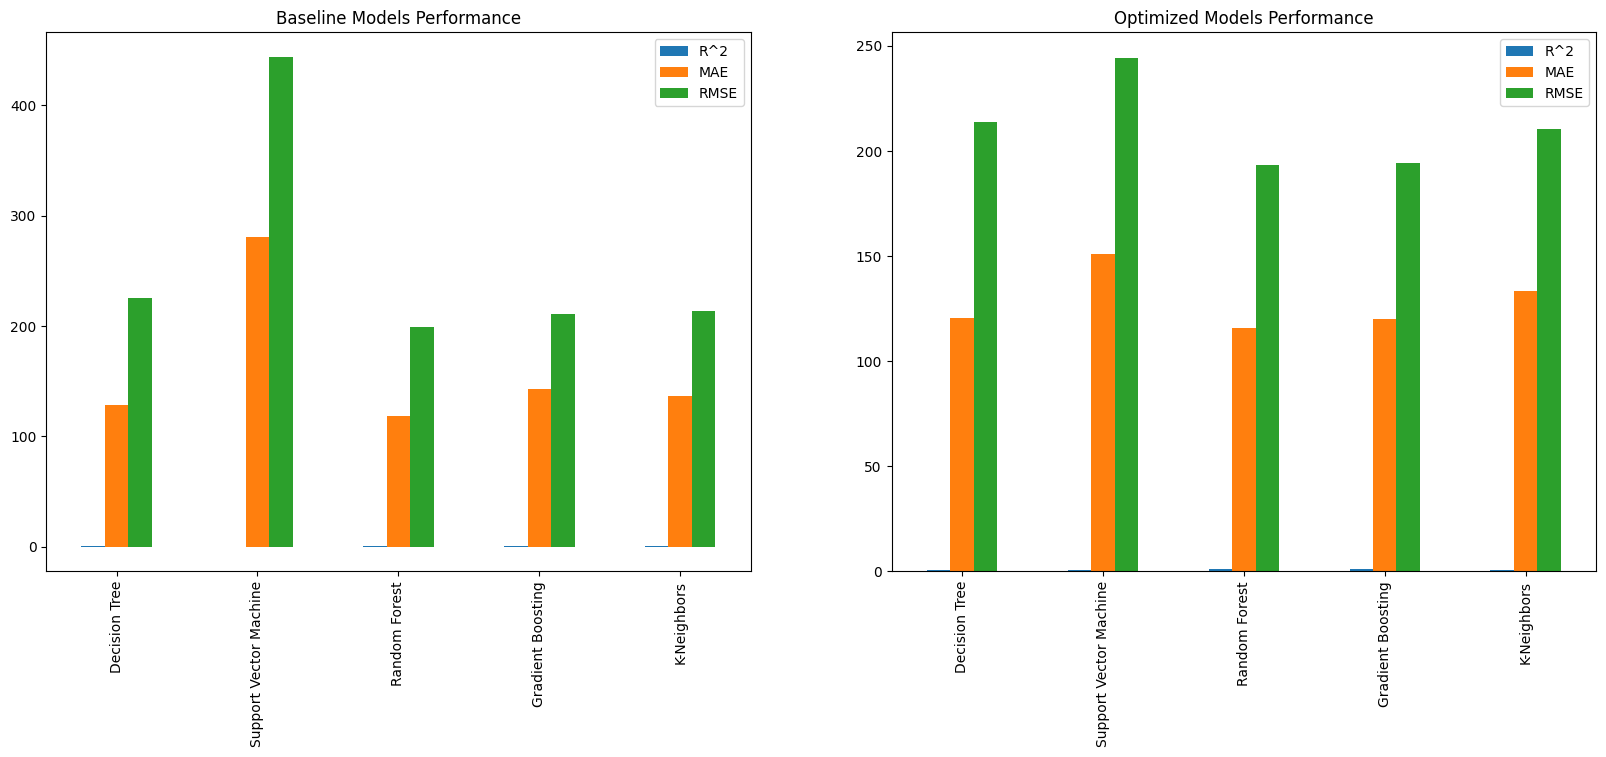

In [17]:
# Компилируем результаты базовых моделей и оптимизированных моделей
comparison_results = {"Baseline": baseline_results, "Optimized": optimized_results}

for category, results in comparison_results.items():
    print(f"\n{category} Models Comparison:")
    for name, metrics in results.items():
        print(f"{name}: R^2: {metrics['R^2']:.4f}, MAE: {metrics['MAE']:.4f}, RMSE: {metrics['RMSE']:.4f}")

# Визуализируем результаты базовых моделей и оптимизированных моделей
baseline_df = pd.DataFrame(baseline_results).T
optimized_df = pd.DataFrame(optimized_results).T

fig, axes = plt.subplots(1, 2, figsize=(20, 7))

baseline_df.plot(kind='bar', ax=axes[0], title='Baseline Models Performance')
optimized_df.plot(kind='bar', ax=axes[1], title='Optimized Models Performance')
print('\n')
plt.show()
print('\n')

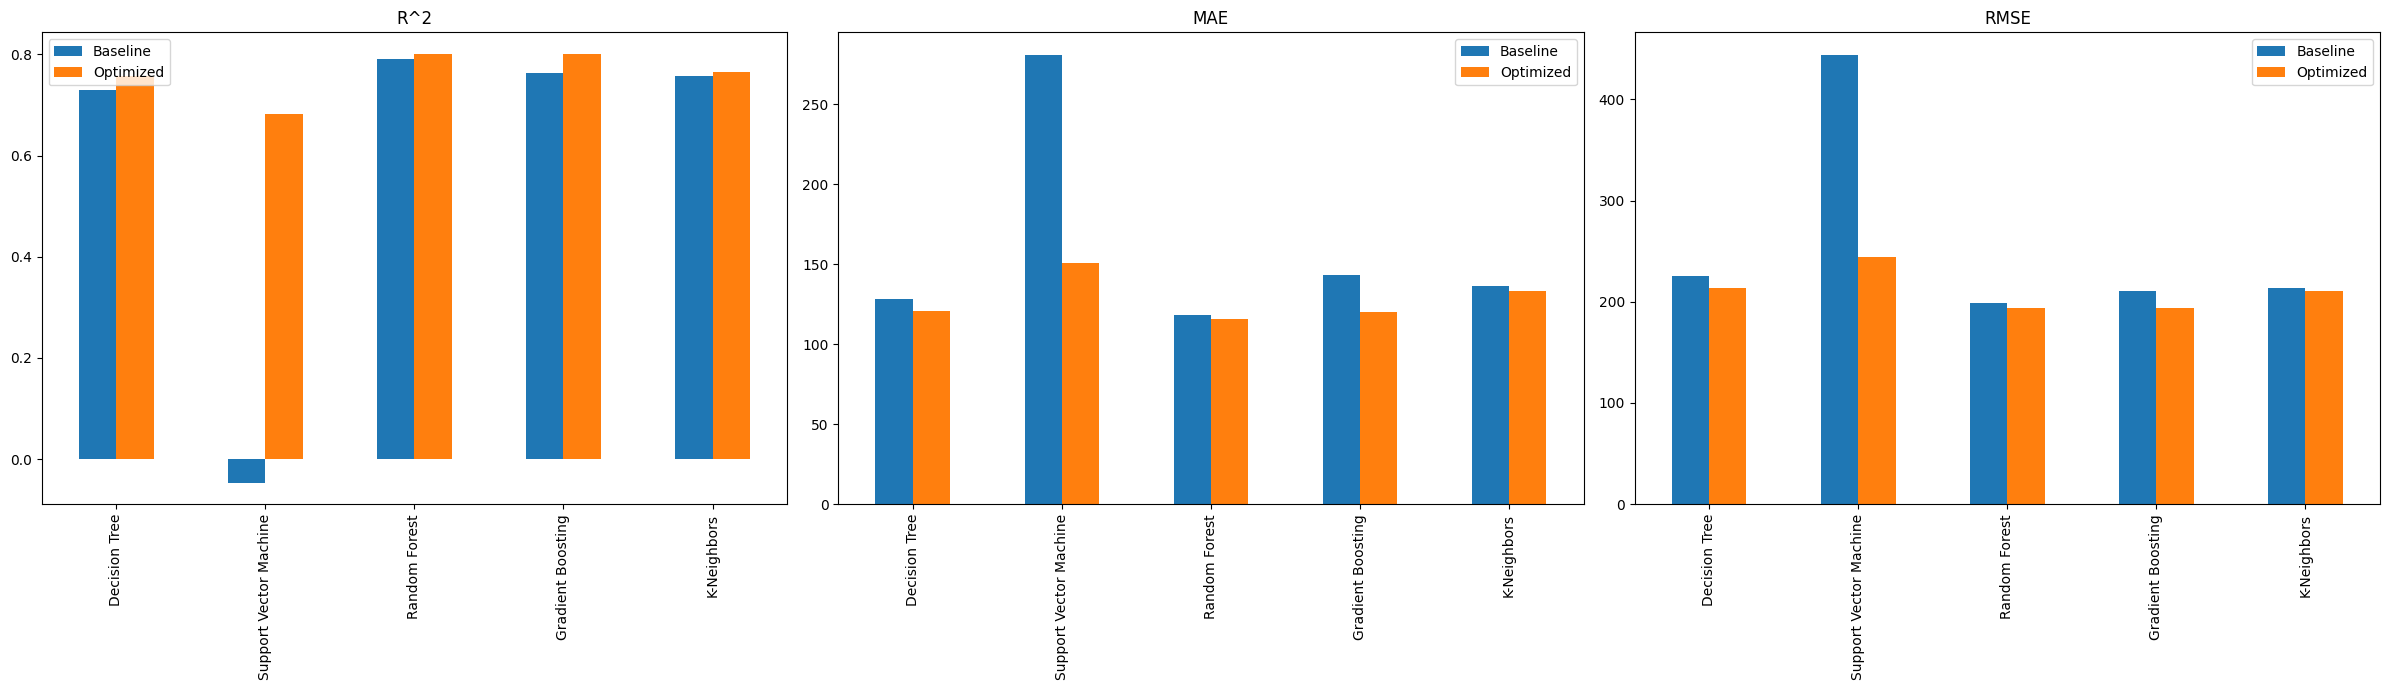

In [18]:
# Превращаем результаты в DataFrame
baseline_df = pd.DataFrame(baseline_results).T
optimized_df = pd.DataFrame(optimized_results).T

# Создаем графики для каждой метрики
metrics = ['R^2', 'MAE', 'RMSE']
fig, axes = plt.subplots(1, 3, figsize=(24, 7))

for i, metric in enumerate(metrics):
    metric_data = pd.DataFrame({
        'Baseline': baseline_df[metric],
        'Optimized': optimized_df[metric]
    })
    metric_data.plot(kind='bar', ax=axes[i], title=metric)

plt.tight_layout()
print('\n')
plt.show()
print('\n')

# Заключение и выводы

#### Описание исследования

В данном исследовании была проведена оценка производительности различных моделей машинного обучения для задачи регрессии. Модели, использованные в исследовании, включают решающее дерево, метод опорных векторов, случайный лес, градиентный бустинг и метод K-ближайших соседей (K-Neighbors).

#### Сравнение моделей

Для каждой модели были измерены три метрики: \( R^2 \) (коэффициент детерминации), MAE (средняя абсолютная ошибка) и RMSE (корень из средней квадратической ошибки). Сравнение проводилось в двух этапах: до оптимизации гиперпараметров (Baseline Models) и после их оптимизации (Optimized Models).

**Baseline Models:**
- **Decision Tree:** \( R^2 = 0.7312 \), MAE = 128.3401, RMSE = 224.9632
- **Support Vector Machine:** \( R^2 = -0.0467 \), MAE = 280.7735, RMSE = 443.9565
- **Random Forest:** \( R^2 = 0.7869 \), MAE = 119.2584, RMSE = 200.3177
- **Gradient Boosting:** \( R^2 = 0.7616 \), MAE = 143.2850, RMSE = 211.8895
- **K-Neighbors:** \( R^2 = 0.7583 \), MAE = 136.5227, RMSE = 213.3348

**Optimized Models:**
- **Decision Tree:** \( R^2 = 0.7894 \), MAE = 120.8185, RMSE = 199.1606
- **Support Vector Machine:** \( R^2 = 0.6831 \), MAE = 150.8910, RMSE = 244.2678
- **Random Forest:** \( R^2 = 0.8039 \), MAE = 114.7374, RMSE = 192.1829
- **Gradient Boosting:** \( R^2 = 0.8007 \), MAE = 116.3280, RMSE = 193.7453
- **K-Neighbors:** \( R^2 = 0.7655 \), MAE = 133.3681, RMSE = 210.1604

#### Выводы

1. **Улучшение после оптимизации гиперпараметров:**
   Все модели показали улучшение после оптимизации гиперпараметров. Это демонстрирует важность процесса настройки гиперпараметров для достижения более высокой производительности модели. Например, R^2 для решающего дерева увеличился с 0.7312 до 0.7894, а MAE уменьшилась с 128.3401 до 120.8185.

2. **Лучшая модель:**
   - Лучшую производительность среди оптимизированных моделей показала модель Random Forest. Она достигла \( R^2 = 0.8039 \), MAE = 114.7374 и RMSE = 192.1829, что свидетельствует о более точных предсказаниях по сравнению с другими моделями.
   - Градиентный бустинг также показал высокую производительность (\( R^2 = 0.8007 \), MAE = 116.3280, RMSE = 193.7453), немного уступая Random Forest по всем метрикам.

3. **Наихудшая производительность:**
   - Методы Support Vector Machine показали наихудшую производительность как до, так и после оптимизации. Особенно это заметно в изначальных результатах, где \( R^2 \) даже отрицательное (-0.0467), что указывает на то, что модель не может предсказывать лучше, чем простое среднее значение целевой переменной.

4. **Другие модели:**
   - Решающее дерево и K-Neighbors также показали улучшение после оптимизации гиперпараметров, но уступили Random Forest и Gradient Boosting по всем метрикам.

## Заключение

На основе результатов анализа, для задачи регрессии на выбранных данных рекомендовано использовать модель случайного леса (Random Forest) или градиентного бустинга (Gradient Boosting) после тщательной настройки гиперпараметров. Эти модели продемонстрировали наилучшие результаты по сравнению с другими рассматриваемыми моделями и могут обеспечить точные и надежные предсказания.